# Aprendizaje de máquina no supervizado, reglas de asociación y PCA
### RafaCastle

# Primera parte

## Obtener el conjunto de artículos frecuentes así como reglas de asociación que se puedan extraer del mismo

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

%matplotlib inline
plt.rcParams['figure.figsize']=[8,8]

## Descripción del Dataset

El Dataset contiene todas las transacciones entre el 01/12/10 y 09/12/2011 para una tienda en línea en el Reino Unido que vende obsequios.

### Información de los atributos:

1. InvoiceNo: Número de factura. Un número integral de 6 dígitos asignado de forma exclusiva a cada transacción. Si este código comienza con la letra 'c', indica una cancelación.

2. StockCode: Código de producto (artículo). Un número integral de 5 dígitos asignado de forma única a cada producto distinto.

3. Description: Nombre del producto (artículo). 

4. Quantity: Las cantidades de cada producto (artículo) por transacción.

5. InvoiceDate: Fecha y hora de entrada. El día y la hora en que se generó cada transacción.

6. UnitPrice: Precio unitario. Precio del producto por unidad en libras esterlinas.

7. CustomerID: Número de cliente. Un número integral de 5 dígitos asignado de forma exclusiva a cada cliente.

8. Country: Nombre del país. El nombre del país donde reside cada cliente.

In [2]:
df = pd.read_csv('Online Retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


Veamos la información del dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Limpieza de datos

Primero se van a llenar los valores nulos, para clientes sin ID - "0". Además se transformará el formato de InvoiceDate a timestamp y de CustomerID a object

In [4]:
df['CustomerID'].fillna(0,inplace=True)
df['CustomerID'] = df['CustomerID'].astype(np.int64)
df['CustomerID'] = df['CustomerID'].astype(object)
df["InvoiceDate"]=pd.to_datetime(df["InvoiceDate"])

## Exploración

Definamos primero un dataset con los pedidos no cancelados

In [5]:
df_nc=df[~df["InvoiceNo"].str.startswith("C")]

Ahora con los pedidos cancelados

In [6]:
df_c=df[df["InvoiceNo"].str.startswith("C")]

### ¿En que mes se realiza la mayor cantidad de compras?

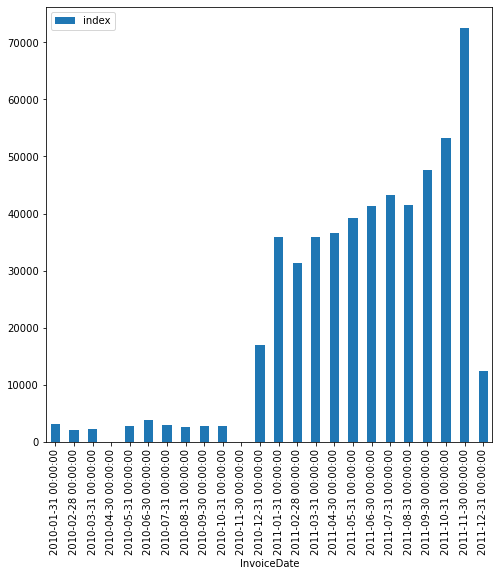

In [7]:
tiempo=df_nc["InvoiceDate"]
tiempo=tiempo.reset_index().set_index("InvoiceDate")
tiempo.groupby(pd.Grouper(freq='1M')).count().plot(kind='bar');

### ¿A qué hora se vende la mayoría de productos?

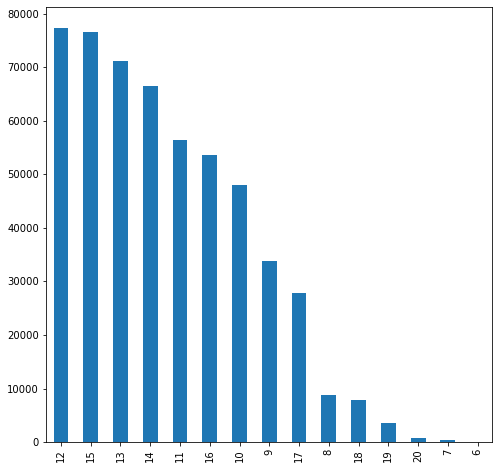

In [8]:
def hr_func(ts):
    return ts.hour
tiempo = df_nc["InvoiceDate"].apply(hr_func)
tiempo.value_counts().plot(kind="bar");

## Artículos comprados más frecuentemente de manera individual

Veamos cuál es el artículo que más frecuentemente se vende, no forzosamente es el artículo que más se venda, ya que en este análisis no vamos a considerar la cantidad de artículos vendidos, sino el artículo que se presenta en la mayoría de facturas. Más adelante analizaremos cuáles son los artículos más vendidos en cuanto a cantidad.

In [9]:
articulos=df_nc[["StockCode","Description"]]
articulos=articulos.dropna()
frecuencias=articulos.value_counts().to_frame().reset_index("Description").rename(columns={0:"Frequency"})
frecuencias.head()

,Description,Frequency
StockCode,,
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2260
85099B,JUMBO BAG RED RETROSPOT,2115
22423,REGENCY CAKESTAND 3 TIER,2019
47566,PARTY BUNTING,1707
20725,LUNCH BAG RED RETROSPOT,1594


Aquí hay un problema, y es que la descripción de algunos productos no está escrita correctamente, veamos un ejemplo

In [10]:
frecuencias.loc["85123A"]

,Description,Frequency
StockCode,,
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2260
85123A,CREAM HANGING HEART T-LIGHT HOLDER,9
85123A,?,1
85123A,wrongly marked carton 22804,1


Vemos que este artículo fue etiquetado de diferentes formas, a pesar de ser el mismo producto, por lo tanto, en las próximas celdas vamos a unificar estas cuentas

In [11]:
codigos_repetidos=[] # los códigos que tienen varias etiquetas, como el anterior

for code in list(set(frecuencias.index)): 
    if len(frecuencias.loc[code])>2: 
        codigos_repetidos.append(code)

In [12]:
etiquetas={} # se va a guardar la etiqueta correcta y la cantidad de frecuencias correcta
for i in codigos_repetidos:
    etiquetas[i]=[frecuencias.loc[i,"Description"][0],
                  sum(frecuencias.loc[i,"Frequency"])]

Este dataframe contiene los artículos que tenían varias etiquetas y fueron corregidos

In [13]:
frec_corregidas=pd.DataFrame(etiquetas).T.rename(columns={0:"Description",1:"Frequency"})
frec_corregidas.sort_values(by="Frequency",ascending=False).head()

,Description,Frequency
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2271
22423,REGENCY CAKESTAND 3 TIER,2022
23203,JUMBO BAG VINTAGE DOILY,1250
23209,LUNCH BAG VINTAGE DOILY,1124
23084,RABBIT NIGHT LIGHT,1042


Ahora eliminamos los renglones repetidos y reemplazamos los renglones con su valor corregido

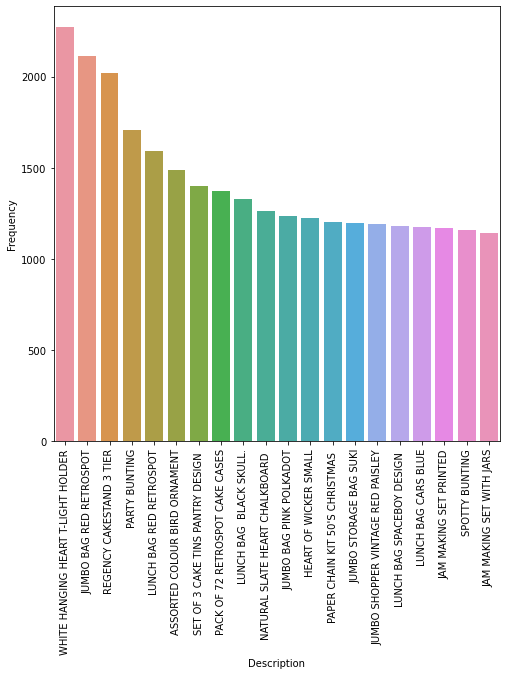

In [14]:
# eliminando los renglones repetidos
index = frecuencias.index
is_duplicate = index.duplicated(keep="first")
not_duplicate = ~is_duplicate
frecuencias = frecuencias[not_duplicate]

# poniendo renglones corregidos
for indice in frec_corregidas.index:
    frecuencias.loc[indice]=frec_corregidas.loc[indice]

sns.barplot(data=frecuencias[:20],x="Description",y="Frequency");
plt.xticks(rotation=90);

## Artículos más vendidos

En este análisis si consideraremos la cantidad, por lo que veremos cuáles son los artículos que más se venden. Sin importar que sea el artículo que más frecuentemente se compra.

In [15]:
articulos=df_nc[["StockCode","Description","Quantity"]]
articulos.head()

,StockCode,Description,Quantity
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,71053,WHITE METAL LANTERN,6
2,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


Veamos los códigos de los artículos que se venden más

In [16]:
ventas=articulos.groupby("StockCode").sum().sort_values("Quantity",ascending=False)
ventas.head()

,Quantity
StockCode,
23843,80995
23166,78033
22197,56921
84077,55047
85099B,48478


Ahora pongamosle las descripciones para ver cuales son los artículos más vendidos

In [17]:
articulos.set_index("StockCode",inplace=True)

In [18]:
# eliminando los renglones repetidos
index = articulos.index
is_duplicate = index.duplicated(keep="first")
not_duplicate = ~is_duplicate
articulos = articulos[not_duplicate]

In [19]:
ventas["Description"]="non"
for indice in ventas.index:
    ventas.loc[indice,"Description"]=articulos.loc[indice,"Description"]

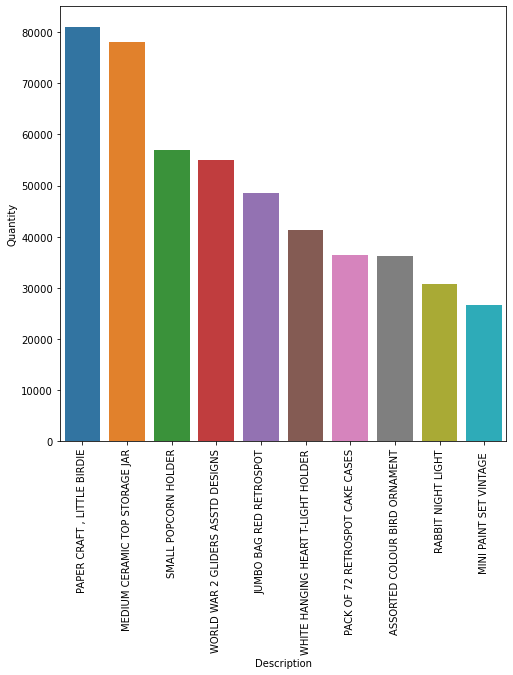

In [20]:
sns.barplot(data=ventas.dropna()[:10],x="Description",y="Quantity");
plt.xticks(rotation=90);

## Conjunto de artículos más frecuentemente vendidos

¿Qué artículos se venden más en conjunto? para responder a esta pregunta hay que ver que artículos se venden por factura.

In [21]:
facturas_df=df_nc[["InvoiceNo","StockCode"]]
facturas=list(set(facturas_df["InvoiceNo"]))
facturas_df.head()

,InvoiceNo,StockCode
0,536365,85123A
1,536365,71053
2,536365,84406B
3,536365,84029G
4,536365,84029E


Se hace una lista de los códigos de los artículos para cada factura:

In [22]:
articulos_factura=[] # aquí se van a guardar las listas con los códigos por factura
gb_fac=facturas_df.groupby("InvoiceNo") # se agrupa por factura
for factura in facturas:
    articulos_factura.append(list(gb_fac.get_group(factura)["StockCode"])) 

Se preparan los datos para el análisis

In [23]:
encoder = TransactionEncoder().fit(articulos_factura)
onehot = encoder.transform(articulos_factura)
onehot = pd.DataFrame(onehot, columns= encoder.columns_)

Se ocupó 0.017 como sporte mínimo por limitaciones computacionales.

In [24]:
frequent_itemset = apriori(onehot, min_support= 0.017, max_len = 3, use_colnames=True)

Se obtiene un histograma para los valores del soporte, nota que la columna itemsets son los códigos de los productos:

,support,itemsets,Description
0,0.023522,(15036),[ASSORTED COLOURS SILK FAN]
1,0.020667,(15056N),[EDWARDIAN PARASOL NATURAL]
2,0.020305,(20676),[RED RETROSPOT BOWL]
3,0.031590,(20685),[DOORMAT RED RETROSPOT]
4,0.023794,(20711),[JUMBO BAG TOYS ]
...,...,...,...
443,0.018718,"(85099B, 22386, 21931)","[JUMBO BAG RED RETROSPOT, JUMBO BAG PINK POLKA..."
444,0.017676,"(85099B, 22411, 21931)","[JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG..."
445,0.017132,"(85099B, 22386, 22411)","[JUMBO BAG RED RETROSPOT, JUMBO BAG PINK POLKA..."
446,0.018492,"(22423, 22699, 22697)","[REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU..."


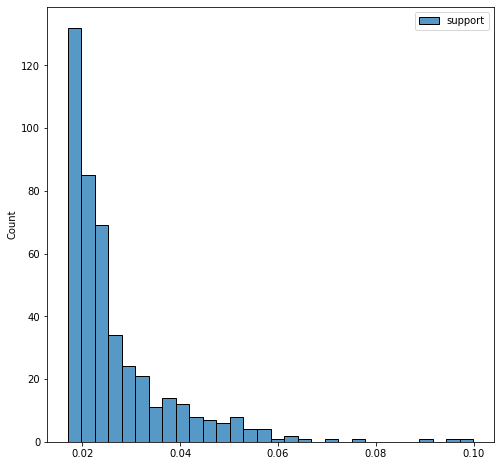

In [25]:
# Cambiando de código de producto a descripción
etiquetas=df_nc[["StockCode","Description"]].set_index("StockCode")
index = etiquetas.index
is_duplicate = index.duplicated(keep="first")
not_duplicate = ~is_duplicate
etiquetas = etiquetas[not_duplicate]

frequent_itemset["Description"]=[list(frequent_itemset["itemsets"][_]) for _ in range(len(frequent_itemset))]

for i in range(len(frequent_itemset)):
    keys=[]
    desc=[]
    itemset=list(frequent_itemset.loc[i,"itemsets"])
    for j in range(len(itemset)):
        keys.append(itemset[j])
        desc.append(etiquetas.loc[keys[j]][0])
        frequent_itemset.loc[i,"Description"][j]=desc[j]
        
sns.histplot(frequent_itemset[["support"]]);
frequent_itemset

## Reglas de asociación

Estas son las reglas de asociación para los artículos

In [26]:
rules = association_rules(frequent_itemset, metric= "lift", min_threshold=1)

# Cambiando de código de producto a descripción
rules["antecedents desc"]=[list(rules["antecedents"][_]) for _ in range(len(rules))]
rules["consequents desc"]=[list(rules["consequents"][_]) for _ in range(len(rules))]

for i in range(len(rules)):
    keys=[]
    desc=[]
    itemset=list(rules.loc[i,"antecedents"])
    for j in range(len(itemset)):
        keys.append(itemset[j])
        desc.append(etiquetas.loc[keys[j]][0])
        rules.loc[i,"antecedents desc"][j]=desc[j]
    
for i in range(len(rules)):
    keys=[]
    desc=[]
    itemset=list(rules.loc[i,"consequents"])
    for j in range(len(itemset)):
        keys.append(itemset[j])
        desc.append(etiquetas.loc[keys[j]][0])
        rules.loc[i,"consequents desc"][j]=desc[j]
        
rules.drop(columns=["antecedents","consequents"])

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents desc,consequents desc
0,0.039113,0.053662,0.020350,0.520278,9.695453,0.018251,1.972680,[JUMBO BAG WOODLAND ANIMALS],[JUMBO STORAGE BAG SUKI]
1,0.053662,0.039113,0.020350,0.379223,9.695453,0.018251,1.547877,[JUMBO STORAGE BAG SUKI],[JUMBO BAG WOODLAND ANIMALS]
2,0.039113,0.055203,0.019443,0.497103,9.004995,0.017284,1.878709,[JUMBO BAG WOODLAND ANIMALS],[JUMBO BAG PINK POLKADOT]
3,0.055203,0.039113,0.019443,0.352217,9.004995,0.017284,1.483346,[JUMBO BAG PINK POLKADOT],[JUMBO BAG WOODLAND ANIMALS]
4,0.039113,0.053254,0.017676,0.451912,8.485945,0.015593,1.727361,[JUMBO BAG WOODLAND ANIMALS],[JUMBO SHOPPER VINTAGE RED PAISLEY]
...,...,...,...,...,...,...,...,...,...
247,0.027148,0.046003,0.024565,0.904841,19.669380,0.023316,10.025342,"[ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",[GREEN REGENCY TEACUP AND SAUCER]
248,0.028689,0.048314,0.024565,0.856240,17.722404,0.023179,6.619970,"[GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",[ROSES REGENCY TEACUP AND SAUCER ]
249,0.048314,0.028689,0.024565,0.508443,17.722404,0.023179,1.975987,[ROSES REGENCY TEACUP AND SAUCER ],"[GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY..."
250,0.046003,0.027148,0.024565,0.533990,19.669380,0.023316,2.087620,[GREEN REGENCY TEACUP AND SAUCER],"[ROSES REGENCY TEACUP AND SAUCER , PINK REGENC..."


## Reflexión de la primera parte

En primer lugar se observa que las mayores ventas en la tienda se efectúan en los meses de septiembre, octubre y noviembre en un horario de 10:00 a 16:00.

Los artículos que se presentan con mayor frecuencia en las facturas son:

    WHITE HANGING HEART T-LIGHT HOLDER
    JUMBO BAG RED RETROSPOT
    REGENCY CAKESTAND 3 TIER
    PARTY BUNTING
    LUNCH BAG RED RETROSPOT
    
Mientras que los artículos más vendidos son:

	PAPER CRAFT , LITTLE BIRDIE
	MEDIUM CERAMIC TOP STORAGE JAR
	SMALL POPCORN HOLDER
	WORLD WAR 2 GLIDERS ASSTD DESIGNS
	JUMBO BAG RED RETROSPOT
    
En general se observa que la relación entre artículos dentro de las facturas es principalmente que los clientes compran el mismo producto variando entre el color y el tamaño de cada uno, esto derivado de que en su mayoría son clientes mayoristas.

Para este caso, se podría implementar reglas de asociación entre los productos sin distinguir por color o tamaño, para distinguir entre productos no relacionados entre sí.

# Segunda parte

## Escoger un conjunto de datos

Datos de tendencias de emisiones de contaminantes atmosféricos

In [27]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
df_p = pd.read_csv('Pollution by type US 1970 to 2016.csv')
df_p.head()

,Source Category,1970,1975,1980,1985,1990,1991,1992,1993,1994,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,FUEL COMB. ELEC. UTIL.,237,276,322,291,363,349,350,363,370,...,703,728,747,766,784,762,739,717,717,717
1,FUEL COMB. INDUSTRIAL,770,763,750,670,879,920,955,1043,1041,...,983,898,919,940,961,960,958,957,957,957
2,FUEL COMB. OTHER,3625,3441,6230,7525,4269,4587,4849,4181,4108,...,2943,2749,2783,2818,2852,2719,2585,2452,2452,2452
3,CHEMICAL & ALLIED PRODUCT MFG,3397,2204,2151,1845,1183,1127,1112,1093,1171,...,191,183,178,173,167,154,142,129,129,129
4,METALS PROCESSING,3644,2496,2246,2223,2640,2571,2496,2536,2475,...,836,840,815,791,766,714,662,609,609,609


## Descripción del Dataset

 El dataset contiene datos sobre las emisiones en miles de toneladas de CO (monóxido de carbono) en Estados Unidos a lo largo de los años. Los renglones del dataset representan las distintas fuentes de emisión de CO, por ejemplo procesamiento de metales, combustibles industriales, etc. 
 
 fuente https://www.epa.gov/air-emissions-inventories/air-pollutant-emissions-trends-data

## Aplicar PCA sobre el mismo para obtener las componentes más importantes

### Limpieza de datos

El data set original ya fue convertido a .csv, en las siguientes líneas se eliminarán las columnas con datos vacíos y se convertiran a enteros angunas columnas.

In [71]:
df_p.replace("NA ", np.nan, inplace=True)
df_p.dropna(inplace=True)

In [72]:
df_p["1970"] = df_p["1970"].astype(np.int64)
df_p["1975"] = df_p["1975"].astype(np.int64)
df_p["1980"] = df_p["1980"].astype(np.int64)

In [73]:
df_p=df_p.set_index("Source Category").T
df_p

Source Category,FUEL COMB. ELEC. UTIL.,FUEL COMB. INDUSTRIAL,FUEL COMB. OTHER,CHEMICAL & ALLIED PRODUCT MFG,METALS PROCESSING,PETROLEUM & RELATED INDUSTRIES,OTHER INDUSTRIAL PROCESSES,WASTE DISPOSAL & RECYCLING,HIGHWAY VEHICLES,OFF-HIGHWAY,MISCELLANEOUS,Wildfires,Stationary fuel combustion,Industrial and other processes,Miscellaneous
1970,237,770,3625,3397,3644,2179,620,7059,163231,11371,7909,6766,4632,16899,7909
1975,276,763,3441,2204,2496,2211,630,3230,153555,14329,5263,4433,4480,10771,5263
1980,322,750,6230,2151,2246,1723,830,2300,143827,16685,8344,7622,7302,9250,8344
1985,291,670,7525,1845,2223,462,694,1941,134187,19029,7927,7289,8486,7216,7927
1990,363,879,4269,1183,2640,333,537,1079,110255,21447,11122,10583,5511,5853,11122
1991,349,920,4587,1127,2571,345,548,1116,104980,21934,8618,10583,5856,5740,8618
1992,350,955,4849,1112,2496,371,544,1138,99705,22419,6934,6389,6154,5683,6934
1993,363,1043,4181,1093,2536,371,594,1248,94431,22904,7082,6537,5587,5898,7082
1994,370,1041,4108,1171,2475,338,600,1225,89156,23389,9656,9089,5519,5838,9656
1995,372,1056,4506,1223,2380,348,624,1185,83881,23874,7298,6705,5934,5791,7298


Se agregan manualmente las décadas, cabe destacar que las décadas correspondientes a 1970 y 1980 contienen solo 2 datos cada una, por lo que en una división 70% - 30% para los datos de entrenamiento y de prueba no resultará eficiente, por lo cual en la siguiente línea los años entre a 1970-1989 serán retirados y no serán considerados en el resto del análisis. 

In [74]:
df_p["Decadas"]=[1,1,2,2,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5]
df_p=df_p[4:]

Se dividen los datos

In [75]:
from sklearn.model_selection import train_test_split
X, y = df_p[list(df_p.columns.drop("Decadas"))].values, df_p["Decadas"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

se escalan los datos

In [76]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Se obtiene la matriz de covarianzas

In [77]:
cov_mat = np.cov(X_train_std.T)

Se obitenen los eigenvalores y eigenvectores

In [78]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals

array([9.10467504e+00, 2.48933652e+00, 1.99883505e+00, 1.04663110e+00,
       7.22941828e-01, 2.48906033e-01, 1.98577347e-01, 4.46053417e-02,
       1.41165094e-02, 7.29270836e-03, 5.52084088e-03, 8.91622319e-04,
       2.29374595e-05, 6.20582217e-08, 1.25608150e-16])

Varianza acumulativa e individual

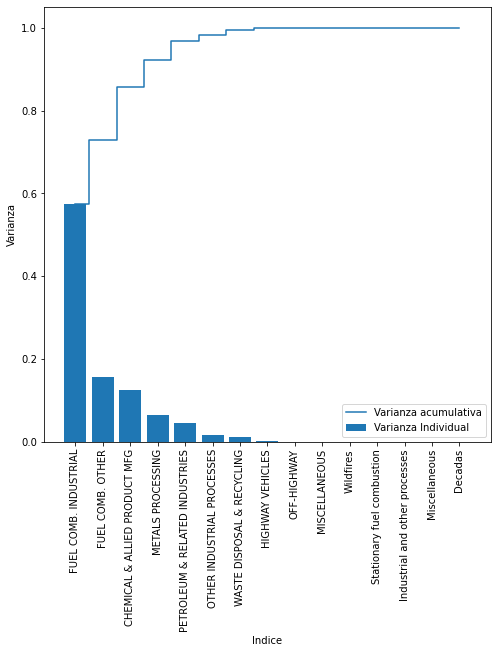

In [79]:
tot = sum(eigen_vals)
var_exp = [ev/tot for ev in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(df_p.columns[1:], var_exp, label = "Varianza Individual", align = "center")
plt.step(df_p.columns[1:], cum_var_exp, where= "mid", label = "Varianza acumulativa")
plt.xlabel("Indice")
plt.ylabel("Varianza")
plt.legend(loc = "best")
plt.xticks(rotation=90);
plt.show()

In [80]:
eigen_par = [(np.abs(eigen_vals[i]), eigen_vecs[i])
              for i in range (len(eigen_vals))]
eigen_par.sort(key = lambda k:k[0], reverse = True)

In [81]:
W = np.hstack((eigen_par[0][1][:, np.newaxis],
               eigen_par[1][1][:,np.newaxis]))
W

array([[ 3.34332491e-01, -1.09008219e-01],
       [ 3.20194756e-02, -2.62355329e-01],
       [-7.16229977e-02, -5.85175798e-01],
       [-1.40603404e-01, -6.96835051e-02],
       [-2.73828800e-02, -1.94900585e-01],
       [ 6.83235942e-02, -2.30746909e-01],
       [-7.07167774e-02, -4.88120502e-01],
       [-5.72330739e-02,  1.13633055e-01],
       [-1.74031951e-01, -7.02548177e-03],
       [ 3.30611153e-01,  3.63363968e-01],
       [-7.98084429e-01,  1.56915281e-01],
       [-2.05983183e-01,  2.23474924e-01],
       [ 1.40391155e-02, -2.07916177e-02],
       [-1.71601765e-01, -1.50058139e-01],
       [ 1.41541583e-10,  1.23777029e-10]])

In [82]:
print("Original : ", X_train_std)
print ("Proyectada : ", X_train_std.dot(W))

Original :  [[ 0.82721199 -0.79247336 -1.22576348 -0.83350962 -0.98164932  2.31341847
   1.12007008  0.67422228 -1.24039661 -1.78448762  0.6333166  -0.16419399
  -1.33703494 -0.06246646  0.6333166 ]
 [ 0.90007141 -1.23035406 -0.76761263 -0.70121515 -0.62644108 -0.74898964
  -1.06536744 -0.56486024 -0.75224639 -0.56570628  0.90815191  0.56103018
  -0.90527711 -1.08287227  0.90815191]
 [ 0.42979698  1.50825575  0.46800632 -0.45377548 -0.40039948 -0.27467727
  -0.29686193 -0.22084761 -0.07504483  0.65591002  0.42567549  1.27812316
   0.9834484  -0.50361324  0.42567549]
 [ 0.33706681  0.65475947  0.13017792 -0.63996771 -0.64335576 -0.30561068
   0.2314856  -0.28455366 -0.39740819  0.47009032 -0.19614629 -1.10392652
   0.3831158  -0.70184494 -0.19614629]
 [-1.47117151 -0.16904999  1.32877458  1.71928372  1.88769516 -0.37263308
   1.0240069  -0.80853586  1.30265944  0.85306961 -1.19671573 -0.64354664
   1.06085519  1.12773619 -1.19671573]
 [ 0.40330264  1.2410743   0.35693945 -0.51502293 -0.

In [83]:
print("Original : ", X_train_std[0])
print ("Proyectada : ", X_train_std[0].dot(W))

Original :  [ 0.82721199 -0.79247336 -1.22576348 -0.83350962 -0.98164932  2.31341847
  1.12007008  0.67422228 -1.24039661 -1.78448762  0.6333166  -0.16419399
 -1.33703494 -0.06246646  0.6333166 ]
Proyectada :  [-0.33045091 -0.45934725]


In [84]:
X_train_pca = X_train_std.dot(W)

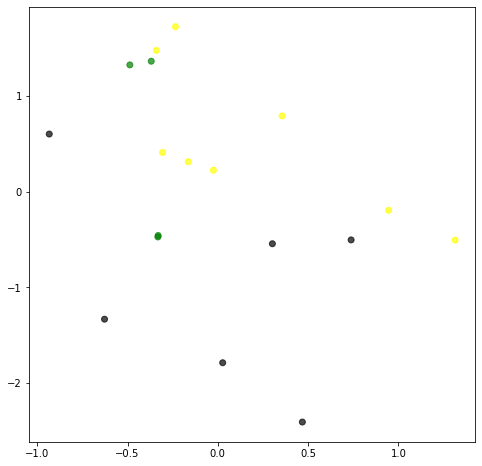

In [85]:
colors = np.array(["", "red", "blue", "black","yellow","green"])
plt.scatter(X_train_pca[:,0], X_train_pca[:, 1],c = colors[y_train],alpha =0.7);

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [87]:
pca = PCA(n_components= 2)
lr = LogisticRegression(multi_class = "auto", solver = "liblinear")

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train)

LogisticRegression(solver='liblinear')

In [88]:
from mlxtend.plotting  import plot_decision_regions

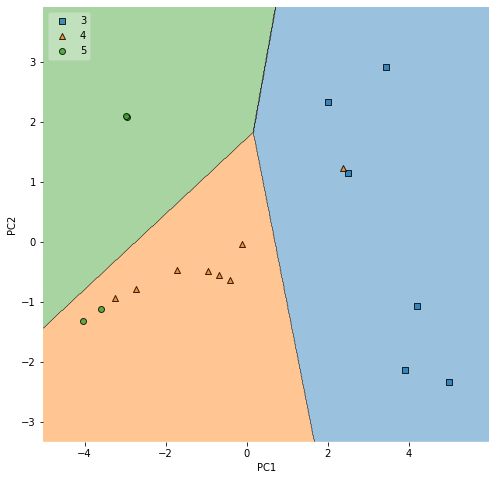

In [89]:
plot_decision_regions(X_train_pca, y_train, clf = lr, legend = 2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

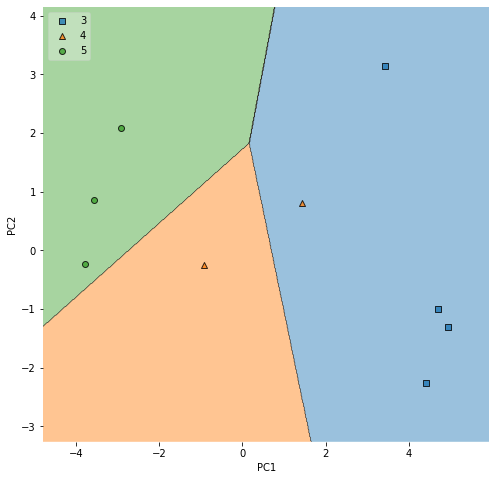

In [90]:
plot_decision_regions(X_test_pca, y_test, clf = lr, legend = 2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Reflexión de la segunda parte

La base analizada contiene información sobre emisiones de contaminantes atmosféricos desde 1970 hasta 2016.

Al realizar una agrupación por década nos percatamos que en las décadas 1970 y 1980 la información contenida no era suficiente para aportar al modelo, por lo cual son décadas que no se consideraron al para las pruebas.

Con la gráfica de aportes se observa que las variables que aportan mayor información son:
    
    FUEL COMB. INDUSTRIAL
    FUEL COMB. OTHER
    CHEMICAL & ALLIED PRODUCT MFG

Dividiendo en 3 grupos las pruebas fueron consistentes, mostrando que las emisiones de EU por año pueden clasificarse por décadas.